## Aufgabe 2 : Schätzung, Test, Prognose und Prognosefehler im multivariaten Modell ##

**Verwendeter Datensatz:** https://www.kaggle.com/datasets/mirichoi0218/insurance

**Ziel:** Vorhersage auf Basis verschiedener unabhängiger Variablen

**Allgemeines Vorgehen:**
1. Daten laden und aufbereiten
2. EDA (Vorstellung des Datensatzes) # jasmina
3. Modellspezifikation # jasmina
4. Modellschätzung # jasmina
6. F-Test # tina
7. Prognose (Fehler) und Prognoseintervalle # tina
8. Test der Annahmen bivariat + (Multikollinearität, Strukturbrüche, Homoskedastizität, Autokorrelation, Normalverteilung) # martin
9. Interpretation

In [1]:
# import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from scipy.stats import levene
from sklearn.feature_selection import f_regression
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

### 1. Daten laden und aufbereiten

In [2]:
# load data
insurance_data = pd.read_csv('insurance.csv')
print(insurance_data.head())
print()
print("shape: ", insurance_data.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

shape:  (1338, 7)


In [3]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# missing data points
print('Missing data points:')
print(insurance_data.isnull().sum())

Missing data points:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [5]:
# one hot encoding
data = pd.get_dummies(insurance_data)
print(data.head())

   age     bmi  children      charges  sex_female  sex_male  smoker_no  \
0   19  27.900         0  16884.92400           1         0          0   
1   18  33.770         1   1725.55230           0         1          1   
2   28  33.000         3   4449.46200           0         1          1   
3   33  22.705         0  21984.47061           0         1          1   
4   32  28.880         0   3866.85520           0         1          1   

   smoker_yes  region_northeast  region_northwest  region_southeast  \
0           1                 0                 0                 0   
1           0                 0                 0                 1   
2           0                 0                 0                 1   
3           0                 0                 1                 0   
4           0                 0                 1                 0   

   region_southwest  
0                 1  
1                 0  
2                 0  
3                 0  
4                 

In [6]:
data.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

### 2. EDA (Vorstellung des Datensatzes)

In [7]:
# Summary statistics
#all
data.describe().round(2)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.00,1338.00,1338.00,1338.00,1338.00,1338.00,1338.0,1338.0,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42,0.49,0.51,0.8,0.2,0.24,0.24,0.27,0.24
std,14.05,6.10,1.21,12110.01,0.50,0.50,0.4,0.4,0.43,0.43,0.45,0.43
min,18.00,15.96,0.00,1121.87,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
25%,27.00,26.30,0.00,4740.29,0.00,0.00,1.0,0.0,0.00,0.00,0.00,0.00
50%,39.00,30.40,1.00,9382.03,0.00,1.00,1.0,0.0,0.00,0.00,0.00,0.00
75%,51.00,34.69,2.00,16639.91,1.00,1.00,1.0,0.0,0.00,0.00,1.00,0.00
max,64.00,53.13,5.00,63770.43,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00


In [8]:
#plot aller numerischen spalten
data[['age', 'bmi', 'children', 'charges']].describe().round(2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


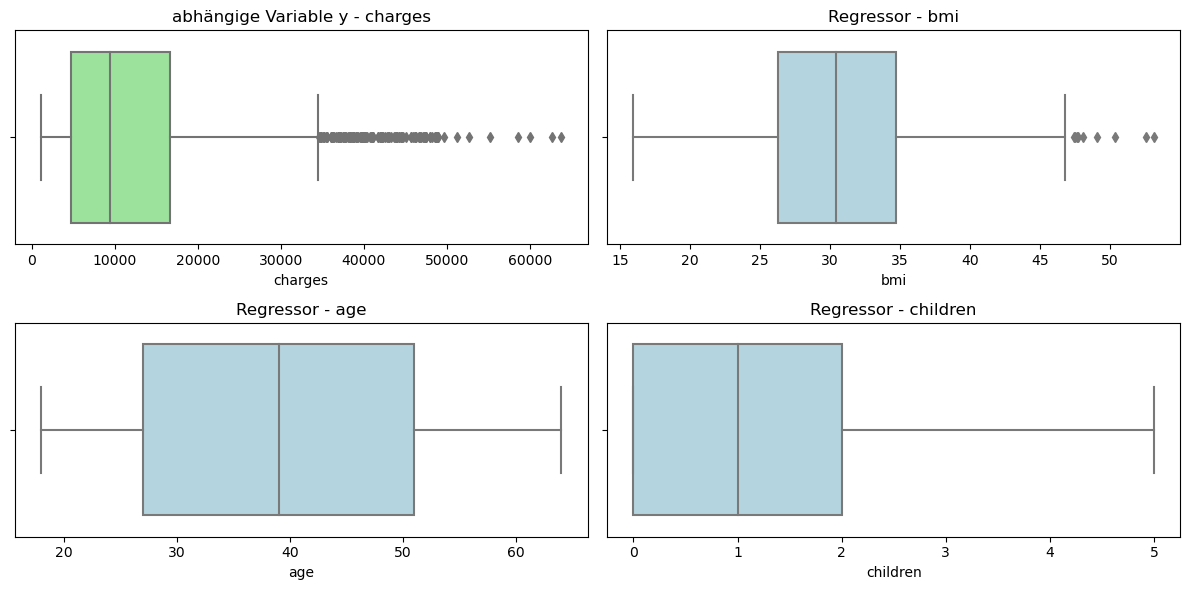

In [9]:
plt.figure(figsize=(12, 6))  

# Boxplot for 'charges'
plt.subplot(2, 2, 1)
sns.boxplot(data=data, x='charges', color='lightgreen')
plt.title('abhängige Variable y - charges')

# Boxplot for 'bmi'
plt.subplot(2, 2, 2)  
sns.boxplot(data=data, x='bmi', color='lightblue')
plt.title('Regressor - bmi')

# Boxplot for 'age'
plt.subplot(2, 2, 3)  
sns.boxplot(data=data, x='age', color='lightblue')
plt.title('Regressor - age')

# Boxplot for 'children'
plt.subplot(2, 2, 4) 
sns.boxplot(data=data, x='children', color='lightblue')
plt.title('Regressor - children')

#plot
plt.tight_layout()
plt.show()

In [10]:
#plot aller Variablen die onehot encodede wurden
data[['sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']].describe().round(2)

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.00,1338.00,1338.0,1338.0,1338.00,1338.00,1338.00,1338.00
mean,0.49,0.51,0.8,0.2,0.24,0.24,0.27,0.24
std,0.50,0.50,0.4,0.4,0.43,0.43,0.45,0.43
min,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.0,0.0,0.00,0.00,0.00,0.00
50%,0.00,1.00,1.0,0.0,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.0,0.0,0.00,0.00,1.00,0.00
max,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00


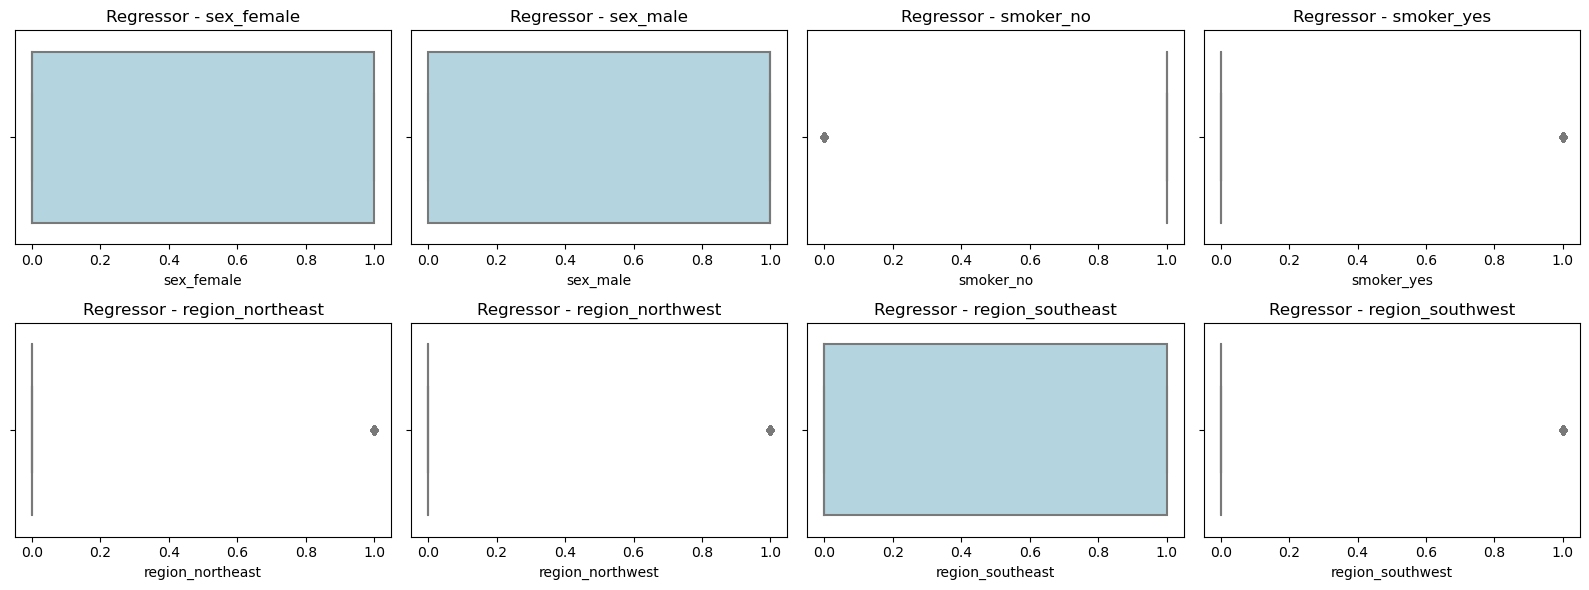

In [11]:
plt.figure(figsize=(16, 6))  

# Boxplot for 'sex_female'
plt.subplot(2, 4, 1)  
sns.boxplot(data=data, x='sex_female', color='lightblue')
plt.title('Regressor - sex_female')

# Boxplot for 'sex_male'
plt.subplot(2, 4, 2)  
sns.boxplot(data=data, x='sex_male', color='lightblue')
plt.title('Regressor - sex_male')

# Boxplot for 'smoker_no'
plt.subplot(2, 4, 3) 
sns.boxplot(data=data, x='smoker_no', color='lightblue')
plt.title('Regressor - smoker_no')

# Boxplot for 'smoker_yes'
plt.subplot(2, 4, 4) 
sns.boxplot(data=data, x='smoker_yes', color='lightblue')
plt.title('Regressor - smoker_yes')

# Boxplot for 'region_northeast'
plt.subplot(2, 4, 5) 
sns.boxplot(data=data, x='region_northeast', color='lightblue')
plt.title('Regressor - region_northeast')

# Boxplot for 'region_northwest'
plt.subplot(2, 4, 6) 
sns.boxplot(data=data, x='region_northwest', color='lightblue')
plt.title('Regressor - region_northwest')

# Boxplot for 'region_southeast'
plt.subplot(2, 4, 7) 
sns.boxplot(data=data, x='region_southeast', color='lightblue')
plt.title('Regressor - region_southeast')

# Boxplot for 'region_southwest'
plt.subplot(2, 4, 8) 
sns.boxplot(data=data, x='region_southwest', color='lightblue')
plt.title('Regressor - region_southwest')

#plot
plt.tight_layout()
plt.show()

Die Grafik zeigt Boxplots für one-hot-kodierte Variablen an, die nur Werte von 0 oder 1 annehmen. 

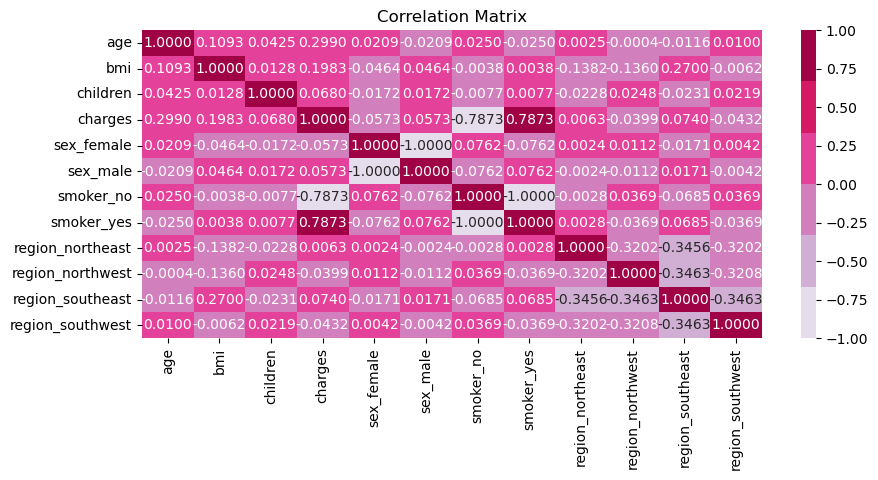

In [12]:
# Data Visualization

num_values = data.select_dtypes(include=[np.number]) # leave out cat values

# Correlation Matrix
correlation_matrix = num_values.corr()

colormap = sns.color_palette("PuRd") 

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap = colormap, annot=True, fmt=".4f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

Korrelation die mit charges sind:
- age: 0.2990
- bmi: 0.1983
- children: 0.0680
- female: -0.0573
- male: 0.0573
- smoker no: -0.7873
- smoker yes: 0.7873
- region ne: 0.0063
- region nw: -0.0399
- region se: 0.0740
- region sw: -0.0432


Die am interessantesten und relevantesten Varibalen bzgl. 'charges' -> mit den "höchsten" Werten sind:
- smoker yes: 0.7873
- age: 0.2990
- bmi: 0.1983

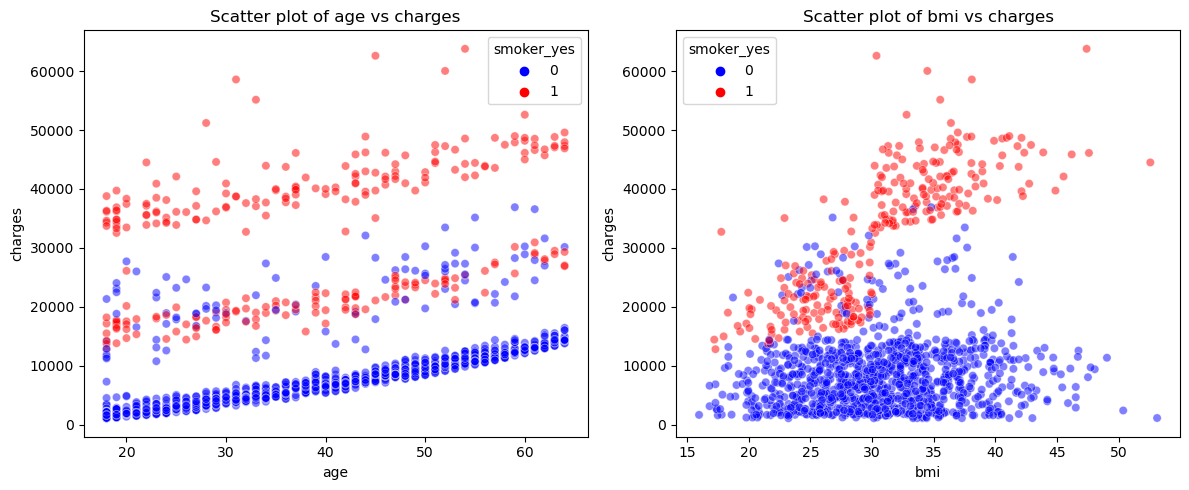

In [13]:
# Scatter plot 
plt.figure(figsize=(12, 5))  

# Scatter plot for 'charges' and 'age'
plt.subplot(1, 2, 1)  
sns.scatterplot(data=data, x='age', y='charges', hue='smoker_yes', palette=['blue', 'red'], alpha=0.5)
plt.title('Scatter plot of age vs charges')  

# Scatter plot for 'charges' and 'bmi'
plt.subplot(1, 2, 2)  
sns.scatterplot(data=data, x='bmi', y='charges', hue='smoker_yes', palette=['blue', 'red'], alpha=0.5)
plt.title('Scatter plot of bmi vs charges')

# Adjust layout
plt.tight_layout()
plt.show()

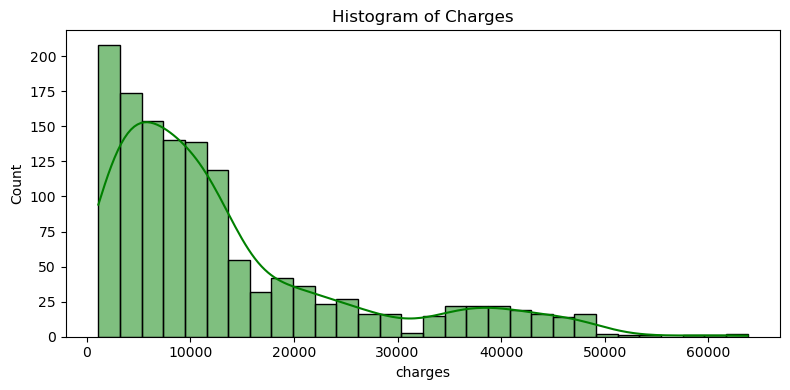

In [14]:
# Set up the plotting figure
plt.figure(figsize=(8, 4))  

# Histogram for 'charges'
sns.histplot(data['charges'], kde=True, color='green', bins=30)
plt.title('Histogram of Charges')

# Display the plot
plt.tight_layout()
plt.show()


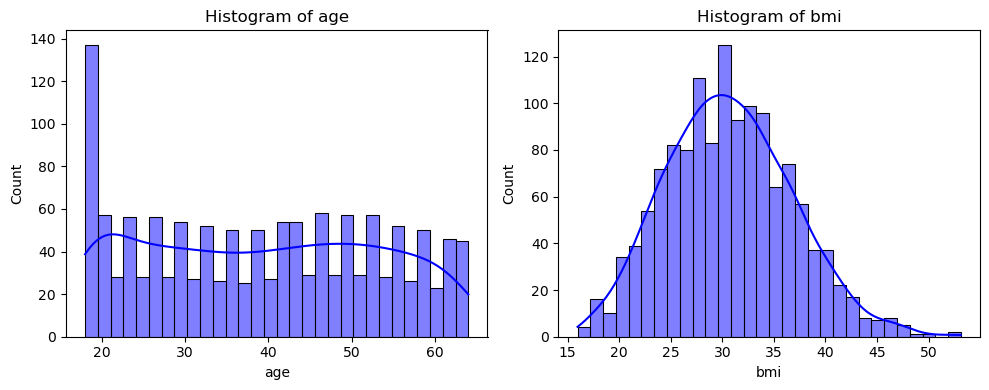

In [15]:
# Scatter plot 
plt.figure(figsize=(10, 4))  

# Histogram for 'age'
plt.subplot(1, 2, 1)  
sns.histplot(data['age'], kde=True, color='blue', bins=30)
plt.title('Histogram of age')

# Histogram for 'bmi'
plt.subplot(1, 2, 2)  
sns.histplot(data['bmi'], kde=True, color='blue', bins=30)
plt.title('Histogram of bmi')

#plot
plt.tight_layout()
plt.show()

### 3. Modellspezifikation und 4. Modellschätzung

In [16]:
# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(data[['age', 'bmi', 'smoker_yes']], data['charges'], test_size=0.2, random_state=42)

In [17]:
# Fit the linear regression model
lr_model = sm.OLS(y_train, X_train)
results = lr_model.fit()

In [18]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              2379.
Date:                Tue, 14 May 2024   Prob (F-statistic):                        0.00
Time:                        14:25:17   Log-Likelihood:                         -10908.
No. Observations:                1070   AIC:                                  2.182e+04
Df Residuals:                    1067   BIC:                                  2.184e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Einfluss der Variablen:
- age: Jedes zusätzliche Lebensjahr erhöht die Kosten um durchschnittlich 200.36 Einheiten (p < 0.001).
- bmi: Ein Anstieg des BMI um eine Einheit führt zu einer durchschnittlichen Kostensteigerung von 35.32 Einheiten (p = 0.047).
- Raucher (smoker_yes): Raucher zahlen im Durchschnitt 23.090 Einheiten mehr als Nichtraucher (p < 0.001).

R²: Der R²-Wert beträgt 0,870 (87%), was bedeutet, dass diese Variablen 87% der Unterschiede in den Kosten erklären und zeigt, wie gut das Modell die Auswirkungen von Alter, BMI und Raucherstatus auf die Kosten erfasst.

In [19]:
y_pred = results.predict(X_test)
print(y_pred[:5])

764      9905.548981
887      8273.435254
890     36864.427153
1293    10126.045150
259     28026.000768
dtype: float64


In [20]:
mse = mean_squared_error(y_test, y_pred).round(2)
print('Mean squared error for age:', mse)

Mean squared error for age: 38862576.73


#### andere Modelle

In [21]:
#Modell mit allen Variablen

# Split the dataset into train and test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(data[['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']], data['charges'], test_size=0.2, random_state=42)

# Fit the linear regression model
lr_model_all = sm.OLS(y_train_all, X_train_all)
results_all = lr_model_all.fit()

print(results_all.summary())

#Ergebnis mit allen Variablen: R²-Wert bei 0.74
#schlechter als primär Modell (0.87)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     380.9
Date:                Tue, 14 May 2024   Prob (F-statistic):          1.32e-305
Time:                        14:25:17   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1061   BIC:                         2.175e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                256.9757     13.477  

In [22]:
#Modell mit 'age', 'bmi', 'children', 'smoker_yes', 'region_northwest'

# Split the dataset into train and test set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data[['age', 'bmi', 'children', 'smoker_yes', 'region_northwest']], data['charges'], test_size=0.2, random_state=42)

# Fit the linear regression model
lr_model_1 = sm.OLS(y_train_1, X_train_1)
results_1 = lr_model_1.fit()

print(results_1.summary())

#Ergebnis mit den 5 Variablen: R²-Wert bei 0.87

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              1432.
Date:                Tue, 14 May 2024   Prob (F-statistic):                        0.00
Time:                        14:25:17   Log-Likelihood:                         -10906.
No. Observations:                1070   AIC:                                  2.182e+04
Df Residuals:                    1065   BIC:                                  2.185e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Ergebnis mit den 5 Variablen (age, bmi, children, smoker_yes, region_northwest): 
- R²-Wert bei 0.87
-  nicht alle zusätzlichen Variablen sind signifikant (p > 0.05)

Modell mit 3 Variablen ist vorzuziehen, da es eine vergleichbare R² besitzt, bei geringerer Komplexität. 
-> Die zusätzlichen Variablen im Modell mit 5 Variablen erhöhen nicht signifikant die Vorhersagekraft und führen zu einer unnötigen Komplikation des Modells.

In [23]:
#Modell mit 'age', 'bmi', 'smoker_yes' + Geschlecht

# Split the dataset into train and test set
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(data[['age', 'bmi', 'smoker_yes','sex_female', 'sex_male']], data['charges'], test_size=0.2, random_state=42)

# Fit the linear regression model
lr_model_s = sm.OLS(y_train_s, X_train_s)
results_s = lr_model_s.fit()

print(results_s.summary())

#Ergebnis der 3 Varibalen + Geschlecht: R²-Wert bei 0.74
#schlechter als primär Modell (0.87)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     754.8
Date:                Tue, 14 May 2024   Prob (F-statistic):          5.68e-309
Time:                        14:25:17   Log-Likelihood:                -10851.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1065   BIC:                         2.174e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          259.4124     13.477     19.249      0.0

In [24]:
#Modell mit 'age', 'bmi', 'smoker_yes' + Regionen

# Split the dataset into train and test set
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(data[['age', 'bmi', 'smoker_yes', 'region_northeast', 'region_northwest','region_southeast', 'region_southwest']], data['charges'], test_size=0.2, random_state=42)

# Fit the linear regression model
lr_model_r = sm.OLS(y_train_r, X_train_r)
results_r = lr_model_r.fit()

print(results_r.summary())

#Ergebnis der 3 Varibalen + Regionen: R²-Wert bei 0.74
#schlechter als primär Modell (0.87)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     503.9
Date:                Tue, 14 May 2024   Prob (F-statistic):          1.13e-306
Time:                        14:25:17   Log-Likelihood:                -10849.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1063   BIC:                         2.175e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                259.2607     13.487  

### 5. (Test der Annahmen (aus bivariater Analyse))

In [25]:
### schwarzt information criterium grafic

In [26]:
### 6. F-Test

# Perform the F-test
f_test = results.f_test(np.eye(len(results.params)))

# Print the F-test results
print(f"F-statistic: {f_test.fvalue[0][0]}")
print(f"P-value: {f_test.pvalue}")

TypeError: 'float' object is not subscriptable

### 7. Prognose (Fehler) und Prognoseintervalle

In [ ]:
# Calculate forecast errors
forecast_errors = results.resid

# Calculate prediction intervals
prediction_intervals = results.get_prediction().conf_int()

# Extract upper and lower bounds of the prediction intervals
lower_bounds = prediction_intervals[:, 0]
upper_bounds = prediction_intervals[:, 1]

# Calculate the width of the prediction intervals
interval_widths = upper_bounds - lower_bounds

# Print or further analyze forecast errors and prediction intervals as needed
print("Forecast Errors:")
print(forecast_errors)

print("Prediction Intervals:")
print(prediction_intervals)


NameError: name 'results' is not defined

NameError: name 'y_pred' is not defined

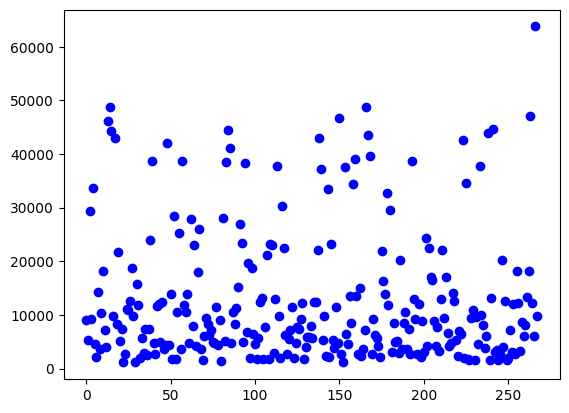

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

# Plot the predicted values
plt.plot(range(len(y_test)), y_pred, color='red', linewidth=2, label='Predicted')

# Plot the prediction intervals
plt.fill_between(range(len(y_test)), lower_bounds, upper_bounds, color='orange', alpha=0.2, label='Prediction Interval')

# Add labels and title
plt.xlabel('Observation')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')

# Add legend
plt.legend()

# Show plot
plt.show()


### 8. Test der Annahmen (Multikollinearität, Strukturbrüche, Homoskedastizität, Autokorrelation, Normalverteilung)